In [1]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import math
import numbers
import random
import torch
import torchvision.transforms as transf
from skimage.transform import rescale, resize, downscale_local_mean
import torch.nn.functional as F
from skimage.transform import resize, rotate
from torchvision.transforms.transforms import RandomCrop as RandomCr
#import F.functional_tensor as F_t
from torchvision.transforms import functional_tensor as F_t
import torchvision.transforms.functional as TVF
import cv2
#from PIL import Image, ImageOps
import numpy as np


In [3]:
np.load("acdc_al_splits.npy", allow_pickle=True)

array({'d_s': ['pat_61_'], 'd_t': ['pat_2_', 'pat_10_', 'pat_22_', 'pat_30_', 'pat_42_', 'pat_50_', 'pat_62_', 'pat_70_', 'pat_82_', 'pat_90_'], 'd_r': ['pat_19_', 'pat_20_', 'pat_39_', 'pat_40_', 'pat_59_', 'pat_60_', 'pat_79_', 'pat_80_', 'pat_99_', 'pat_100_'], 'd_v': ['pat_1_', 'pat_3_', 'pat_4_', 'pat_5_', 'pat_6_', 'pat_7_', 'pat_8_', 'pat_9_', 'pat_21_', 'pat_23_', 'pat_24_', 'pat_25_', 'pat_26_', 'pat_27_', 'pat_28_', 'pat_29_', 'pat_41_', 'pat_43_', 'pat_44_', 'pat_45_', 'pat_46_', 'pat_47_', 'pat_48_', 'pat_49_', 'pat_63_', 'pat_64_', 'pat_65_', 'pat_66_', 'pat_67_', 'pat_68_', 'pat_69_', 'pat_81_', 'pat_83_', 'pat_84_', 'pat_85_', 'pat_86_', 'pat_87_', 'pat_88_', 'pat_89_']},
      dtype=object)

In [2]:
img_npy = '/mnt/qb/baumgartner/cschmidt77_data/acdc/slices/train/pat_7_diag_2_frame_01_slice_5.npy'
mask_npy = '/mnt/qb/baumgartner/cschmidt77_data/acdc/gt/train/pat_7_diag_2_frame_01_slice_5.npy'
img, mask = np.load(img_npy), np.load(mask_npy)

In [3]:
img = torch.from_numpy(img)
mask = torch.from_numpy(mask).long()

In [ ]:
class RandomCropRegion(object):
    def __init__(self, size, padding=0, region_size=(128, 128)):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.padding = padding
        self.region_size = region_size

    def __call__(self, img, mask, region):
        if self.padding > 0:
            pad_img = nn.ConstantPad2d(self.padding, img.min().item()) #padding with the smallest value in tensor (not 0!)
            pad_mask = nn.ConstantPad2d(self.padding, mask.min().item())
            img = pad_img(img)
            mask = pad_mask(mask)
        assert img.shape == mask.shape
        w, h = img.shape #img.size
        th, tw = self.size
        if w == tw and h == th:
            return img, mask
        if w < tw or h < th:
            img_resized, mask_resized = resize(img, (tw, th), anti_aliasing=True), resize(mask, (tw, th), anti_aliasing=True)
            img, mask = torch.from_numpy(img_resized), torch.from_numpy(mask_resized)
            return img, mask#img.resize((tw, th), torch.nn.Upsample('Bilinear')), mask.resize((tw, th), torch.nn.Upsample('nearest'))

        # Get upper left corner of the crop
        y1 = random.randint(max(0, region[1] + self.region_size[1] // 2 - th),
                            min(region[1] + self.region_size[1] // 2, h - th))
        x1 = random.randint(max(0, region[0] + self.region_size[0] // 2 - tw),
                            min(region[0] + self.region_size[0] // 2, w - tw))

        img = img[x1:x1+tw, y1:y1+th]
        mask = mask[x1:x1+tw, y1:y1+th]
        
        return img, mask

In [ ]:
random_cr = RandomCropRegion((200,200), padding=1, region_size=(200, 200))
rcr_croppi = random_cr(img, mask, (0,100))

In [ ]:
plt.imshow(rcr_croppi[0])

In [ ]:
class CropRegion(object):
    '''
    Crops the image so that the region is always contained inside
    '''

    def __init__(self, size, padding=0, region_size=128):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.padding = padding
        self.region_size = 128

    def __call__(self, img, mask, region):
        if self.padding > 0:
            #img = ImageOps.expand(img, border=self.padding, fill=0)
            #mask = ImageOps.expand(mask, border=self.padding, fill=0)
            pad_img = nn.ConstantPad2d(self.padding, img.min().item()) #padding with the smallest value in tensor (not 0!)
            pad_mask = nn.ConstantPad2d(self.padding, mask.min().item())
            img = pad_img(img)
            mask = pad_mask(mask)
        #img = F.pad(img, padding = (self.padding, self.padding, self.padding, self.padding), mode='constant', value=0)
        assert img.shape == mask.shape#assert img.size == mask.size
        w, h = img.shape #img.size
        th, tw = self.size
        if w == tw and h == th:
            return img, mask
        if w < tw or h < th:
            img_resized, mask_resized = resize(img, (tw, th), anti_aliasing=True), resize(mask, (tw, th), anti_aliasing=True)
            img, mask = torch.from_numpy(img_resized), torch.from_numpy(mask_resized)
            return img, mask
            #return img.resize((tw, th), Image.BILINEAR), mask.resize((tw, th), Image.NEAREST)
            #return img.resize((tw, th), torch.nn.Upsample('Bilinear')), mask.resize((tw, th), torch.nn.Upsample('nearest'))
        # Get upper left corner of the crop
        y1 = random.randint(max(0, region[1] + self.region_size - th), min(region[1], h - th))
        x1 = random.randint(max(0, region[0] + self.region_size - tw), min(region[0], w - tw))

        #img_cropped = crop(img, ((x1, x1+tw), (y1, y1+th)), copy=False)
        #mask_cropped = crop(mask, ((x1, x1+tw), (y1, y1+th)), copy=False)
        #img, mask = torch.from_numpy(img_cropped), torch.from_numpy(mask_cropped)
        img = img[x1:x1+tw, y1:y1+th]
        mask = mask[x1:x1+tw, y1:y1+th]
        return img, mask

In [ ]:
cr = CropRegion((180,180), padding=1, region_size=(128, 128))
cr_croppi = cr(image_resized, mask_resized, [80,90])

In [ ]:
plt.imshow(cr_croppi[0])

In [ ]:
class RandomHorizontallyFlip(object):
    def __call__(self, img, mask, region=None):
        #if random.random() < 0.5:
            #return img.transpose(Image.FLIP_LEFT_RIGHT), mask.transpose(Image.FLIP_LEFT_RIGHT)
            #print('img.shape: ', type(img))
        img = torch.from_numpy(img)
        return TVF.hflip(img), TVF.hflip(mask)
        #return img, mask

In [ ]:
rhf = RandomHorizontallyFlip()
flippe = rhf(img, mask)

In [ ]:
flippe

In [ ]:
plt.imshow(flippe[0])

In [ ]:
plt.imshow(img_t)

In [ ]:
def crop_or_pad_slice_to_size(self, img_slice, nx, ny):
    """
    To crop the input 2D slice for the given dimensions
    input params :
        image_slice : 2D slice to be cropped
        nx : dimension in x
        ny : dimension in y
    returns:
        slice_cropped : cropped 2D slice
    """
    slice_cropped=np.zeros((nx,ny))
    x, y = img_slice.shape

    x_s = (x - nx) // 2
    y_s = (y - ny) // 2
    x_c = (nx - x) // 2
    y_c = (ny - y) // 2

    if x > nx and y > ny:
        slice_cropped = img_slice[x_s:x_s + nx, y_s:y_s + ny]
    else:
        slice_cropped = np.zeros((nx, ny))
        if x <= nx and y > ny:
            slice_cropped[x_c:x_c + x, :] = img_slice[:, y_s:y_s + ny]
        elif x > nx and y <= ny:
            slice_cropped[:, y_c:y_c + y] = img_slice[x_s:x_s + nx, :]
        else:
            slice_cropped[x_c:x_c + x, y_c:y_c + y] = img_slice[:, :]

    return slice_cropped

In [ ]:
from skimage import transform
class Scale_Random(object):
    def __call__(self, img, mask, region=None):
        assert img.shape == mask.shape #assert img.size == mask.size
        n_x, n_y = img.shape
        #scale factor between 0.9 and 1.1
        scale_fact_min=0.9
        scale_fact_max=1.1
        scale_val = round(random.uniform(scale_fact_min,scale_fact_max), 2)
        slice_rescaled = transform.rescale(img, scale_val, order=1, preserve_range=True, mode = 'constant')
        img = crop_or_pad_slice_to_size(self, slice_rescaled, n_x, n_y)
        return img, mask

In [ ]:
scale_obj = Scale_Random()
scaled_img_mask = scale_obj(img_t, mask)


In [ ]:
plt.imshow(scaled_img_mask[0])

In [ ]:
class FreeScale(object):
    def __init__(self, size):
        self.size = tuple(reversed(size))  # size: (h, w)

    def __call__(self, img, mask):
        assert img.shape == mask.shape #assert img.size == mask.size
        #return img.resize(self.size, Image.BILINEAR), mask.resize(self.size, Image.NEAREST)
        img_resized, mask_resized = resize(img, self.size, anti_aliasing=True), resize(mask, self.size, anti_aliasing=True)
        img, mask = torch.from_numpy(img_resized), torch.from_numpy(mask_resized)
        return img, mask

In [ ]:
class SmallRotation(object):
    def __call__(self, img, mask):
        angles = [-15,15]
        random_angle = np.random.uniform(angles[0], angles[1])
        return rotate(img, random_angle), rotate(mask, random_angle)


In [ ]:
class RandomRotation(object):
    def __call__(self, img, mask):
        fixed_angle = 45
        random_angle = np.random.randint(8)*fixed_angle
        img, mask = rotate(img, random_angle), rotate(mask, random_angle)
        return torch.from_numpy(img), torch.from_numpy(mask)


In [ ]:
img_t = torch.from_numpy(img)

In [ ]:
rr = RandomRotation()
rr_img_mask = rr(img_t, mask)

In [ ]:
img_flipped = np.fliplr(img)

In [ ]:
plt.imshow(img_flipped)

In [ ]:
rr_img_mask[0].shape

In [ ]:
rr_img_mask.shape

In [ ]:
plt.imshow(rr_img_mask[0])

In [ ]:
class Scale(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, img, mask, region=None):
        assert img.shape == mask.shape #assert img.size == mask.size
        w, h = img.shape #img.size
        if (w >= h and w == self.size) or (h >= w and h == self.size):
            return img, mask
        if w > h:
            ow = self.size
            oh = int(self.size * h / w)
            #return img.resize((ow, oh), Image.BILINEAR), mask.resize((ow, oh), Image.NEAREST)
            img_resized, mask_resized = resize(img, (ow, oh), anti_aliasing=True), resize(mask, (ow, oh), anti_aliasing=True)
            img, mask = torch.from_numpy(img_resized), torch.from_numpy(mask_resized)
            return img, mask
        else:
            oh = self.size
            ow = int(self.size * w / h)
            #return img.resize((ow, oh), Image.BILINEAR), mask.resize((ow, oh), Image.NEAREST)
            img_resized, mask_resized = resize(img, (ow, oh), anti_aliasing=True), resize(mask, (ow, oh), anti_aliasing=True)
            img, mask = torch.from_numpy(img_resized), torch.from_numpy(mask_resized)
            return img, mask

In [ ]:
scale = Scale(80)
sc = scale(img, mask)

In [ ]:
plt.imshow(sc[0])

In [ ]:
class RandomVerticalFlip(object):
    def __call__(self, img):
        if random.random() < 0.5:
            #return img.transpose(Image.FLIP_LEFT_RIGHT), mask.transpose(Image.FLIP_LEFT_RIGHT)
            #print('img.shape: ', type(img))
            return TVF.vflip(img)
        else:
            return img

In [ ]:
rvf = RandomVerticalFlip()
rf = rvf(img)
plt.imshow(rf)

In [ ]:
import elasticdeform.torch as etorch

In [ ]:
class ElasticTransform(object):
    def __call__(self, X, mask):
        X_val = np.random.rand(200, 300)
        dY_val = np.random.rand(200, 300)
        displacement_val = np.random.randn(2, 3, 3)*5
        displacement = torch.tensor(displacement_val)
        X = np.array(X)
        X = torch.tensor(X_val, requires_grad=True)
        dY = torch.tensor(dY_val)
        X_deformed = etorch.deform_grid(X, displacement, order=3)
        X_deformed.backward(dY)
        return X_deformed
        

In [ ]:
el = ElasticTransform()
el_img = el(img, mask)

In [ ]:
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates

In [ ]:
class ElasticDeformation(object):
    def __call__(self, image, mask, alpha_range, sigma, random_state=None):
        """Elastic deformation of images as described in Simard, Steinkraus and Platt, "Best Practices for
        Convolutional Neural Networks applied to Visual Document Analysis", in Proc. of the International Conference on Document Analysis and
        Recognition, 2003.

        # Arguments
        image: Numpy array with shape (height, width, channels). 
        alpha_range: Float for fixed value or [lower, upper] for random value from uniform distribution.
        Controls intensity of deformation.
        sigma: Float, sigma of gaussian filter that smooths the displacement fields.
        random_state: `numpy.random.RandomState` object for generating displacement fields.
        """
        assert image.shape == mask.shape
        if random_state is None:
            random_state = np.random.RandomState(None)

        if np.isscalar(alpha_range):
            alpha = alpha_range
        else:
            alpha = np.random.uniform(low=alpha_range[0], high=alpha_range[1])

        shape = image.shape
        dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
        dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha

        x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')#np.arange(shape[2]), indexing='ij')
        indices = np.reshape(x+dx, (-1, 1)), np.reshape(y+dy, (-1, 1))#, np.reshape(z, (-1, 1))

        img = map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)
        mask = map_coordinates(mask, indices, order=1, mode='reflect').reshape(shape)

        return torch.from_numpy(img), torch.from_numpy(mask)

In [ ]:
# alpha controls deformation intensity and sigma controls displacement field smoothing
et = ElasticDeformation()
elt, mask_elt = et(img_t, mask, 100, 7, None)

In [ ]:
plt.imshow(elt)

In [ ]:
plt.imshow(mask_elt)

In [ ]:
elt.shape

In [ ]:
plt.imshow(img_t)

In [ ]:
import torchvision

In [ ]:
def color_jitter(img, mask, brightness=0, contrast=0, saturation=0, hue=0):
    # Create img transform function sequence
    img = torch.stack((img, img, img), dim=0)
    mask = torch.stack((mask, mask, mask), dim=0)
    img_transforms = []

    if np.isscalar(brightness):
        brightness = brightness
    else:
        brightness = np.random.uniform(low=brightness[0], high=brightness[1])
    
    if np.isscalar(contrast):
        contrast = contrast
    else:
        contrast = np.random.uniform(low=contrast[0], high=contrast[1])
    
    if np.isscalar(saturation):
        saturation = saturation
    else:
        saturation = np.random.uniform(low=saturation[0], high=saturation[1])
    
    if np.isscalar(hue):
        hue = hue
    else:
        hue = np.random.uniform(low=hue[0], high=hue[1])

    if brightness is not None:
        img_transforms.append(lambda img: torchvision.transforms.functional.adjust_brightness(img, brightness))
    if saturation is not None:
        img_transforms.append(lambda img: torchvision.transforms.functional.adjust_saturation(img, saturation))
    if hue is not None:
        img_transforms.append(
            lambda img: torchvision.transforms.functional.adjust_hue(img, hue))
    if contrast is not None:
        img_transforms.append(lambda img: torchvision.transforms.functional.adjust_contrast(img, contrast))
    random.shuffle(img_transforms)

    jittered_img = img
    print(jittered_img.shape)
    #jittered_img = torch.reshape(jittered_img, (256,256))
    for func in img_transforms:
        jittered_img = func(jittered_img)
        jittered_mask = func(mask)

    return jittered_img[0], jittered_mask[0]

In [ ]:
jittered, jittered_mask = color_jitter(img_t, mask, brightness=[0.1, 0.9], contrast=[0.1,0.9], saturation=[0.1,0.9], hue = [-0.3, 0.3])

In [ ]:
class RandomContrastBrightness(object):
    def __call__(img, mask, brightness=None, contrast=None, saturation=None, hue=None):
        # Create img transform function sequence
        img = torch.stack((img, img, img), dim=0)
        mask = torch.stack((mask, mask, mask), dim=0)
        img_transforms = []

        if np.isscalar(brightness):
            brightness = brightness
        else:
            brightness = np.random.uniform(low=brightness[0], high=brightness[1])
        
        if np.isscalar(contrast):
            contrast = contrast
        else:
            contrast = np.random.uniform(low=contrast[0], high=contrast[1])
        
        if np.isscalar(saturation):
            saturation = saturation
        else:
            saturation = np.random.uniform(low=saturation[0], high=saturation[1])
        
        if np.isscalar(hue):
            hue = hue
        else:
            hue = np.random.uniform(low=hue[0], high=hue[1])

        if brightness is not None:
            img_transforms.append(lambda img: torchvision.transforms.functional.adjust_brightness(img, brightness))
        if saturation is not None:
            img_transforms.append(lambda img: torchvision.transforms.functional.adjust_saturation(img, saturation))
        if hue is not None:
            img_transforms.append(
                lambda img: torchvision.transforms.functional.adjust_hue(img, hue))
        if contrast is not None:
            img_transforms.append(lambda img: torchvision.transforms.functional.adjust_contrast(img, contrast))
        random.shuffle(img_transforms)

        jittered_img = img
        print(jittered_img.shape)
        #jittered_img = torch.reshape(jittered_img, (256,256))
        for func in img_transforms:
            jittered_img = func(jittered_img)
            jittered_mask = func(mask)

        return jittered_img[0], jittered_mask[0]

In [ ]:
class RandomContrastBrightness(object):
    def __call__(self, img, mask, region=None):
        # Create img transform function sequence
        assert img.shape == mask.shape
        if random.random() < 0.5:
            print("Random Contrast Brightness")
            brightness=[0.01, 0.99]
            contrast=[-127, 127]
            brightness = np.random.uniform(low=brightness[0], high=brightness[1])
            contrast = np.random.uniform(low=contrast[0], high=contrast[1])
            img = brightness * img + contrast
        return img, mask

In [ ]:
rCB = RandomContrastBrightness()

In [ ]:
img_cont, mask_cont = rCB(img, mask)

In [ ]:
img_cont

In [ ]:
#fig, ax = plt.subplots(1,1, figsize=(10,8))
#ax[0].imshow(img_cont) #mask
#ax[1].imshow(img) #mask
plt.imshow(img_cont)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(mask) #mask
ax[1].imshow(mask_cont) #mask

In [ ]:
mask = torch.from_numpy(mask)

In [ ]:
img = torch.from_numpy(img)

In [ ]:
def crop_or_pad_slice_to_size(self, img_slice, nx, ny):
    """
    To crop the input 2D slice for the given dimensions
    input params :
        image_slice : 2D slice to be cropped
        nx : dimension in x
        ny : dimension in y
    returns:
        slice_cropped : cropped 2D slice
    """
    slice_cropped=np.zeros((nx,ny))
    x, y = img_slice.shape

    x_s = (x - nx) // 2
    y_s = (y - ny) // 2
    x_c = (nx - x) // 2
    y_c = (ny - y) // 2

    if x > nx and y > ny:
        slice_cropped = img_slice[x_s:x_s + nx, y_s:y_s + ny]
    else:
        slice_cropped = np.zeros((nx, ny))
        if x <= nx and y > ny:
            slice_cropped[x_c:x_c + x, :] = img_slice[:, y_s:y_s + ny]
        elif x > nx and y <= ny:
            slice_cropped[:, y_c:y_c + y] = img_slice[x_s:x_s + nx, :]
        else:
            slice_cropped[x_c:x_c + x, y_c:y_c + y] = img_slice[:, :]

    return slice_cropped

In [ ]:
class Scale_Random(object):
    def __call__(self, img, mask, region=None):
        if random.random() < 0.5:
            assert img.shape == mask.shape #assert img.size == mask.size
            n_x, n_y = img.shape
            #scale factor between 0.9 and 1.1
            scale_fact_min=0.8
            scale_fact_max=1.2 
            scale_val = round(random.uniform(scale_fact_min,scale_fact_max), 2)
            slice_rescaled, mask_rescaled = rescale(img, scale_val, order=1, preserve_range=True, mode = 'constant'), rescale(mask, scale_val, order=1, preserve_range=True, mode = 'constant')
            #print(type(slice_rescaled))
            img, mask = crop_or_pad_slice_to_size(self, slice_rescaled, n_x, n_y), crop_or_pad_slice_to_size(self, mask_rescaled, n_x, n_y)
            img, mask = torch.from_numpy(img), torch.from_numpy(mask)
        return img, mask

In [ ]:
sr = Scale_Random()
img_scaled, mask_scaled = sr(img, mask)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(img_scaled) #mask
ax[1].imshow(img) #mask

In [ ]:
mask

In [ ]:
import torchio as tio

In [ ]:

class RandomCropRegion(object):
    def __init__(self, size, padding=0, region_size=(128, 128)):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.padding = padding
        self.region_size = region_size

    def __call__(self, img, mask, region):
        if self.padding > 0:
            #img = ImageOps.expand(img, border=self.padding, fill=0)
            #mask = ImageOps.expand(mask, border=self.padding, fill=0)
            pad_img = nn.ConstantPad2d(self.padding, img.min().item()) #padding with the smallest value in tensor (not 0!)
            pad_mask = nn.ConstantPad2d(self.padding, mask.min().item())
            img = pad_img(img)
            mask = pad_mask(mask)
        #img = F.pad(img, pad = (self.padding, self.padding, self.padding, self.padding), mode='constant', value=0)
        assert img.shape == mask.shape
        w, h = img.shape #img.size
        th, tw = self.size
        if w == tw and h == th:
            return img, mask
        if w < tw or h < th:
            img_resized, mask_resized = resize(img, (tw, th), anti_aliasing=True), resize(mask, (tw, th), anti_aliasing=True)
            img, mask = torch.from_numpy(img_resized), torch.from_numpy(mask_resized)
            return img, mask#img.resize((tw, th), torch.nn.Upsample('Bilinear')), mask.resize((tw, th), torch.nn.Upsample('nearest'))

        # Get upper left corner of the crop
        y1 = random.randint(max(0, region[1] + self.region_size[1] // 2 - th),
                            min(region[1] + self.region_size[1] // 2, h - th))
        x1 = random.randint(max(0, region[0] + self.region_size[0] // 2 - tw),
                            min(region[0] + self.region_size[0] // 2, w - tw))
        
        #img_cropped = crop(img, ((x1, x1+tw), (y1, y1+th)), copy=False)
        #mask_cropped = crop(mask, ((x1, x1+tw), (y1, y1+th)), copy=False)
        #img, mask = torch.from_numpy(img_cropped), torch.from_numpy(mask_cropped)
        img = img[x1:x1+tw, y1:y1+th]
        mask = mask[x1:x1+tw, y1:y1+th]
        # print("in RandomCropRegion mask: ", mask)
        # print("mask.min(): ", mask.min())
        # print("mask.max()", mask.max())
        if torch.is_tensor(img):
            return img, mask
        else:
            return torch.from_numpy(img), torch.from_numpy(mask)

In [ ]:
from PIL import Image, ImageOps
class RandomCropRegion_old(object):
    def __init__(self, size, padding=0, region_size=(128, 128)):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.padding = padding
        self.region_size = region_size

    def __call__(self, img, mask, region):
        if self.padding > 0:
            img = ImageOps.expand(img, border=self.padding, fill=0)
            mask = ImageOps.expand(mask, border=self.padding, fill=0)

        assert img.size == mask.size
        w, h = img.size
        th, tw = self.size
        if w == tw and h == th:
            return img, mask
        if w < tw or h < th:
            return img.resize((tw, th), Image.BILINEAR), mask.resize((tw, th), Image.NEAREST)
        # Get upper left corner of the crop
        y1 = random.randint(max(0, region[1] + self.region_size[1] // 2 - th),
                            min(region[1] + self.region_size[1] // 2, h - th))
        x1 = random.randint(max(0, region[0] + self.region_size[0] // 2 - tw),
                            min(region[0] + self.region_size[0] // 2, w - tw))
        return img.crop((x1, y1, x1 + tw, y1 + th)), mask.crop((x1, y1, x1 + tw, y1 + th))

In [ ]:
rcro = RandomCropRegion_old(size=[128,128], padding=0, region_size=[64,64])

In [ ]:
img_npy = '/mnt/qb/baumgartner/cschmidt77_data/acdc/slices/train/pat_7_diag_2_frame_01_slice_5.npy'
mask_npy = '/mnt/qb/baumgartner/cschmidt77_data/acdc/gt/train/pat_7_diag_2_frame_01_slice_5.npy'
img_np, mask_np = np.load(img_npy), np.load(mask_npy)

In [ ]:
from matplotlib import cm
im = Image.fromarray(np.uint8(img_np)*255)
mas = Image.fromarray(np.uint8(mask_np)*255)

In [ ]:
# train_joint_transform = tio.Compose([
#                         tio.CropOrPad((input_size[0], input_size[1], 1)),
#                         tio.RandomFlip(axes='A'), #horizontal flip
#                         tio.OneOf({
#                             tio.RandomAffine(scales=(0.8,1.2), degrees=(-15, 15), default_pad_value='minimum', image_interpolation='nearest'): 0.8,
#                             tio.RandomElasticDeformation(num_control_points=4, max_displacement=20, locked_borders=0): 0.1,
#                             tio.RandomGamma(log_gamma=(-0.3, 0.3)): 0.1
#                         })
#                     ])
input_size = [128,128]
region_size = [64,64]
train_joint_transform_region = RandomCropRegion(128, region_size=region_size)

train_joint_transform_acdc_al = tio.Compose([
        tio.CropOrPad((input_size[0], input_size[1], 1)),
        tio.RandomFlip(axes='A', flip_probability=0.5), #horizontal flip
        tio.OneOf({
            tio.RandomAffine(scales=(0.9,1.1), degrees=(-15, 15), default_pad_value='minimum', image_interpolation='nearest'): 0.8,
            tio.RandomElasticDeformation(num_control_points=5, max_displacement=2, locked_borders=1): 0.2,
            tio.RandomGamma(log_gamma=(-0.3, 0.3)): 0.1
        })
    ])

In [4]:
import torchio as tio
#image = tio.datasets.Slicer().MRHead.as_sitk()

In [5]:
red = 0

In [6]:

red = tio.RandomElasticDeformation(num_control_points=4, max_displacement=0.5, locked_borders=0)
#red = tio.RandomElasticDeformation(5)

In [7]:
img_unsqueezed = img.unsqueeze(0).unsqueeze(3)

In [8]:
isq = red(img_unsqueezed)

In [9]:
img_t = torch.squeeze(isq)

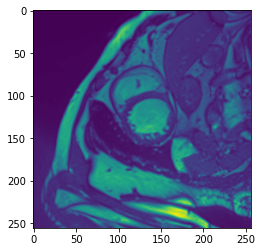

In [10]:
plt.imshow(img_t)

In [11]:
img_t

tensor([[-1.1271, -1.1271, -1.1271,  ..., -0.5857, -0.7007, -0.8079],
        [-1.1271, -1.1271, -1.1271,  ..., -0.7036, -0.7241, -0.7185],
        [-1.1271, -1.1271, -1.1271,  ..., -0.5567, -0.5457, -0.5446],
        ...,
        [-0.7354, -0.7498, -0.7388,  ..., -0.8570, -0.8511, -0.8388],
        [-0.7621, -0.7528, -0.7517,  ..., -0.8545, -0.8441, -0.8354],
        [-0.7622, -0.7610, -0.7693,  ..., -0.8603, -0.8518, -0.8484]])

In [12]:
img

tensor([[-1.1271, -1.1271, -1.1271,  ..., -0.5773, -0.6988, -0.8139],
        [-1.1271, -1.1271, -1.1271,  ..., -0.7133, -0.7362, -0.7304],
        [-1.1271, -1.1271, -1.1271,  ..., -0.5635, -0.5470, -0.5409],
        ...,
        [-0.7338, -0.7522, -0.7358,  ..., -0.8580, -0.8522, -0.8393],
        [-0.7621, -0.7508, -0.7507,  ..., -0.8546, -0.8440, -0.8352],
        [-0.7622, -0.7608, -0.7706,  ..., -0.8609, -0.8524, -0.8492]])

In [ ]:
plt.imshow(img)

In [ ]:
img_npy = '/mnt/qb/baumgartner/cschmidt77_data/acdc/slices/train/pat_7_diag_2_frame_01_slice_5.npy'
mask_npy = '/mnt/qb/baumgartner/cschmidt77_data/acdc/gt/train/pat_7_diag_2_frame_01_slice_5.npy'
img_np, mask_np = np.load(img_npy), np.load(mask_npy)
img, mask = torch.from_numpy(img_np), torch.from_numpy(mask_np)
#img, mask = train_joint_transform_region(img, mask, (64,128))
#img, mask = train_joint_transform_acdc_al(img, mask)
img_unsqueezed = img.unsqueeze(0).unsqueeze(3) #adds two additional dims (required from torch io) 
mask_unsqueezed = mask.unsqueeze(0).unsqueeze(3)
subject = tio.Subject(
    img=tio.ScalarImage(tensor=img_unsqueezed), 
    mask=tio.LabelMap(tensor=mask_unsqueezed)
)
# performs other transforms
transformed = train_joint_transform_acdc_al(subject)
img_transf = transformed.img.numpy()
mask_transf = transformed.mask.numpy()
img_t = torch.from_numpy(img_transf)
mask_t = torch.from_numpy(mask_transf)
img = torch.squeeze(img_t) #removes dimensions of size 1
mask = torch.squeeze(mask_t.long()) 

In [ ]:
plt.imshow(img)

In [ ]:
plt.imshow(mask)